In [77]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [78]:
# Define the conversion rates for each variation of the web page
conversion_rates = [0.04, 0.05, 0.03, 0.02, 0.06]

def pull_arm(arm):
    """
    Simulates playing an arm of the multi-armed bandit and returns the reward.
    
    Parameters:
        arm (int): The index of the arm to play.
        
    Returns:
        float: The reward obtained by playing the specified arm (conversion rate).
    """
    # Simulate a visitor to the web page
    if random.random() < conversion_rates[arm]:
        # The visitor converted
        reward = 1
    else:
        # The visitor did not convert
        reward = 0

    return reward


In [79]:
def epsilon_greedy(num_arms, n, epsilon, pull_arm):
    # Initialize the estimated reward for each arm to 0
    estimated_rewards = [0] * num_arms

    # Play the bandit for n steps
    for i in range(n):
        # Select an arm
        if random.random() < epsilon:
            # Choose a random arm with probability epsilon
            arm = random.randint(0, num_arms-1)
        else:
            # Choose the arm with the highest estimated reward with probability 1-epsilon
            arm = max(range(num_arms), key=lambda x: estimated_rewards[x])

        # Pull the arm and observe the reward
        reward = pull_arm(arm)

        # Update the estimated reward for the selected arm
        estimated_rewards[arm] = (estimated_rewards[arm] * i + reward) / (i+1)

    return estimated_rewards


In [80]:
def ucb(num_arms, n, pull_arm):
    """
    Runs the Upper Confidence Bound (UCB) algorithm for the multi-armed bandit problem.
    
    Parameters:
        num_arms (int): The number of arms (i.e., actions) in the bandit.
        n (int): The total number of steps to run the algorithm for.
        pull_arm (function): A function that takes an integer argument (the index of an arm) and returns a float reward.
        
    Returns:
        list of floats: The estimated rewards for each arm after playing the bandit for n steps.
    """
    # Initialize the number of times each arm has been pulled and the sum of the rewards obtained from each arm
    num_pulls = [0] * num_arms
    sum_rewards = [0] * num_arms

    # Play each arm once initially
    for i in range(num_arms):
        reward = pull_arm(i)
        num_pulls[i] += 1
        sum_rewards[i] += reward

    # Play the remaining steps using the UCB algorithm
    for t in range(num_arms, n):
        # Calculate the upper confidence bound for each arm
        ucb_values = []
        for i in range(num_arms):
            if num_pulls[i] == 0:
                # If an arm has not been pulled yet, set the UCB value to infinity
                ucb_values.append(math.inf)
            else:
                # Otherwise, calculate the UCB value using the formula
                ucb_value = sum_rewards[i] / num_pulls[i] + math.sqrt(2 * math.log(t) / num_pulls[i])
                ucb_values.append(ucb_value)

        # Choose the arm with the highest UCB value
        chosen_arm = ucb_values.index(max(ucb_values))

        # Play the chosen arm and update the number of times it has been pulled and the sum of the rewards obtained from it
        reward = pull_arm(chosen_arm)
        num_pulls[chosen_arm] += 1
        sum_rewards[chosen_arm] += reward

    # Return the estimated rewards for each arm
    return [sum_rewards[i] / num_pulls[i] if num_pulls[i] > 0 else 0 for i in range(num_arms)]


In [81]:
def thompson_sampling(num_arms, n, conversion_rates):
    """
    Simulates playing a multi-armed bandit using the Thompson Sampling algorithm and returns the estimated rewards for each arm.
    
    Parameters:
        num_arms (int): The number of arms (variations) of the bandit.
        n (int): The number of times the bandit should be played.
        conversion_rates (list): The true conversion rates for each arm.
        
    Returns:
        list: The estimated rewards for each arm after playing the bandit for n steps.
    """
    # Initialize variables for the beta distributions
    alpha = np.ones(num_arms)
    beta = np.ones(num_arms)
    
    # Play the bandit for n steps
    for i in range(n):
        # Sample from the beta distributions to get the probabilities
        probs = [random.betavariate(alpha[j], beta[j]) for j in range(num_arms)]
        
        # Choose the arm with the highest probability
        chosen_arm = np.argmax(probs)
        
        # Simulate playing the chosen arm and get the reward
        reward = 1 if random.random() < conversion_rates[chosen_arm] else 0
        
        # Update the beta distribution for the chosen arm based on the reward
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        
    # Calculate the estimated rewards for each arm as the mean of the beta distributions
    estimated_rewards = [alpha[j] / (alpha[j] + beta[j]) for j in range(num_arms)]
    
    return estimated_rewards

In [82]:
def softmax(num_arms, n, conversion_rates, tau=0.1):
    """
    Simulates playing a multi-armed bandit using the Softmax algorithm and returns the estimated rewards for each arm.
    
    Parameters:
        num_arms (int): The number of arms (variations) of the bandit.
        n (int): The number of times the bandit should be played.
        conversion_rates (list): The true conversion rates for each arm.
        tau (float): The temperature parameter for the Softmax function. Defaults to 0.1.
        
    Returns:
        list: The estimated rewards for each arm after playing the bandit for n steps.
    """
    # Initialize variables for the action values
    action_values = np.zeros(num_arms)
    
    # Play the bandit for n steps
    for i in range(n):
        # Calculate the probabilities of choosing each arm using the Softmax function
        probabilities = np.exp(action_values / tau) / np.sum(np.exp(action_values / tau))
        
        # Choose an arm based on the probabilities
        chosen_arm = np.argmax(probabilities)
        
        # Simulate playing the chosen arm and get the reward
        reward = 1 if random.random() < conversion_rates[chosen_arm] else 0
        
        # Update the action value of the chosen arm based on the reward using the incremental update rule
        action_values[chosen_arm] += (reward - action_values[chosen_arm]) / (i + 1)
        
    # Return the estimated rewards for each arm
    return action_values

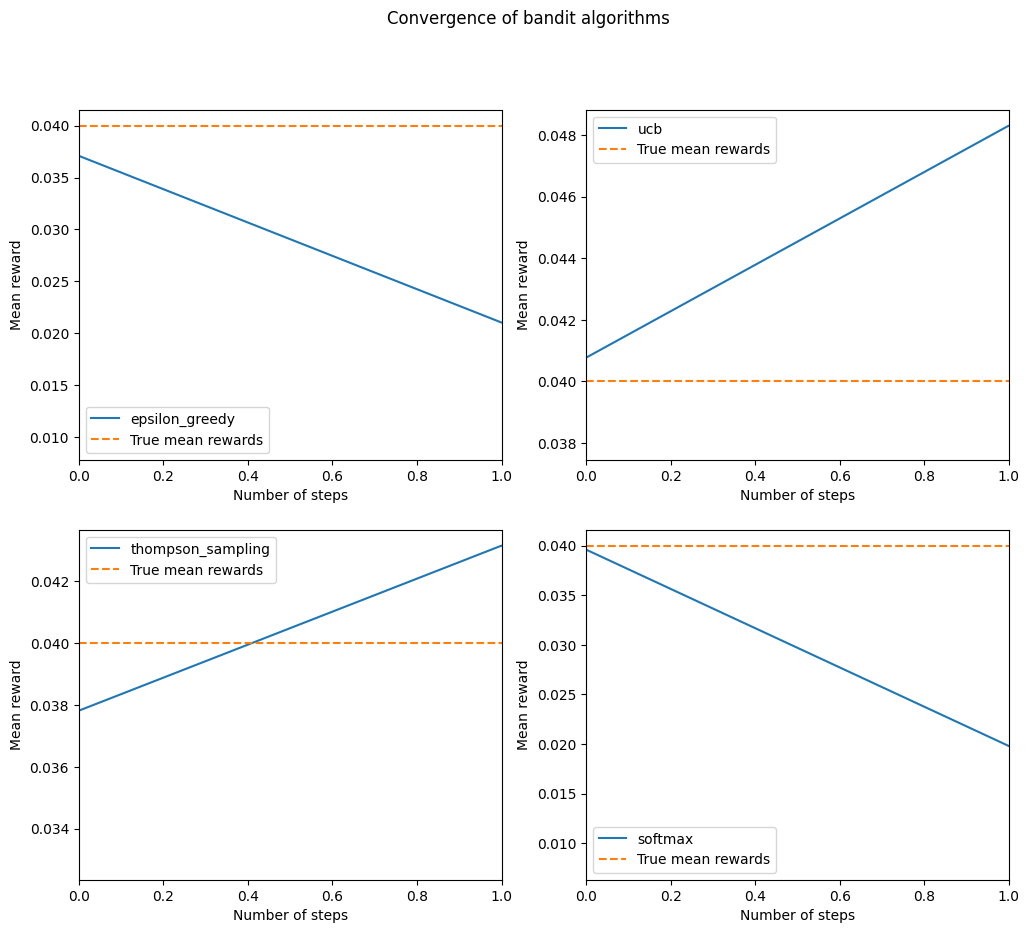

In [85]:
num_arms = 5
n = 1000
epsilon = 0.1
pull_arm = lambda arm: np.random.binomial(1, conversion_rates[arm])
estimated_rewards = epsilon_greedy(num_arms, n, epsilon, pull_arm)
bandit_functions = [epsilon_greedy, ucb, thompson_sampling, softmax]
all_rewards=[estimated_rewards]

n = 5000
estimated_rewards = ucb(num_arms, n, pull_arm)
all_rewards.append(estimated_rewards)

estimated_rewards = thompson_sampling(num_arms, n, conversion_rates)
all_rewards.append(estimated_rewards)

tau = 0.1
estimated_rewards = softmax(num_arms, n, conversion_rates, tau)
all_rewards.append(estimated_rewards)


true_mean_rewards = [np.mean(conversion_rates)] * n

# Plot the convergence of each algorithm in terms of mean values
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Convergence of bandit algorithms")
for i, rewards in enumerate(all_rewards):
    mean_rewards = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    row = i // 2
    col = i % 2
    axs[row, col].plot(mean_rewards, label=bandit_functions[i].__name__)
    axs[row, col].plot(true_mean_rewards, label="True mean rewards", linestyle="--")
    axs[row, col].set_xlabel("Number of steps")
    axs[row, col].set_ylabel("Mean reward")
    axs[row, col].set_xlim([0, 1])
    axs[row, col].legend()
plt.show()

